In [20]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from scipy.stats import ks_2samp
from interface import MFDataGenerator
from test_bench import load_movielens_ratings
from torch_model import TorchDataGenerator
import os.path
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [22]:
if os.path.exists("data.pickle"):
    with open("data.pickle", "rb") as f:
        rating_matrix = pickle.load(f)
        id_to_user = pickle.load(f)
        id_to_item = pickle.load(f)
else:
    ratings = load_movielens_ratings()
    rating_matrix, id_to_user, id_to_item = ratings

    with open("data.pickle", "wb") as f:
        pickle.dump(rating_matrix, f)
        pickle.dump(id_to_user, f)
        pickle.dump(id_to_item, f)

In [23]:
if os.path.exists("mf.pickle"):
    with open("mf.pickle", "rb") as f:
        mf = pickle.load(f)
else:
    mf = TorchDataGenerator(rating_matrix, 20)
    mf._build_mf(200)
    
    with open("mf.pickle", "wb") as f:
        pickle.dump(mf, f)


In [44]:
configs = [
    (0.5, True, np.arange(1.0, 30.0, 3.0)),
    (1.0, True, np.arange(1.0, 30.0, 3.0)),
    (2.0, True, np.arange(1.0, 30.0, 3.0)),
    (4.0, True, np.arange(1.0, 30.0, 3.0)),
    (0.5, False, np.arange(1.0, 30.0, 3.0)),
    (1.0, False, np.arange(1.0, 30.0, 3.0)),
    (2.0, False, np.arange(1.0, 30.0, 3.0)),
    (4.0, False, np.arange(1.0, 30.0, 3.0))
]

best_model = None
best_score = 1.0

for logloss_coef, ilc, scales in configs:
    with open("mf.pickle", "rb") as f:
        mf = pickle.load(f)
    
    mf.verbose = True
    mf.epochs = 150
    mf._build_torch_model(200)
    mf._train_torch_model(logloss_coef, lr=4e-3, implicit_logloss=ilc)
    
    mf.user_vectors = mf.model.user_factors.weight.detach().numpy()
    mf.item_vectors = mf.model.item_factors.weight.detach().numpy()
    mf.item_proba_vectors = mf.model.item_implicit_factors.weight.detach().numpy()
    mf._build_gmm(10)
    
    for coef in scales:
        generated = mf.generate(300, False, False, implicit_coef=coef)
        score = ks_2samp(list(generated.values()), list(rating_matrix.data)).statistic
        print(score, logloss_coef, ilc, coef)
        if score > best_score:
            best_model = mf
            score = best_score


d:\onedrive\projects\aimchess-analytics\venv\lib\site-packages\torch\nn\modules\loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([1, 256])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
d:\onedrive\projects\aimchess-analytics\venv\lib\site-packages\torch\nn\modules\loss.py:512: UserWarning: Using a target size (torch.Size([484])) that is different to the input size (torch.Size([1, 484])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch  0 RMSE 0.04012860776501075 Proba loss 0.7865575773418708 Total loss 0.43340739607810974
Epoch  1 RMSE 0.05820803678388359 Proba loss 0.7152516985970903 Total loss 0.4158338861156056
Epoch  2 RMSE 0.11765266261027969 Proba loss 0.6202081581411775 Total loss 0.4277567412258711
Epoch  3 RMSE 0.12182385262585323 Proba loss 0.5685720254901712 Total loss 0.40610986508182595
Epoch  4 RMSE 0.09707972183160048 Proba loss 0.5101016551332013 Total loss 0.35213055012335304
Epoch  5 RMSE 0.08760489347099348 Proba loss 0.4490486680703005 Total loss 0.3121292273355198
Epoch  6 RMSE 0.09059994687200654 Proba loss 0.43714708044328765 Total loss 0.3091734869941197
Epoch  7 RMSE 0.09095287957150518 Proba loss 0.3912153816556809 Total loss 0.28656057031403365
Epoch  8 RMSE 0.09371014751740388 Proba loss 0.38637512793371087 Total loss 0.28689771128519803
Epoch  9 RMSE 0.08943565209270585 Proba loss 0.3553742442953071 Total loss 0.2671227741029123
Epoch  10 RMSE 0.0921924875494633 Proba loss 0.347044

KeyboardInterrupt: 

In [ ]:
with open("mf_trained.pickle", "wb") as f:
    pickle.dump(best_model, f)


In [34]:
with open("mf_trained.pickle", "rb") as f:
    mf = pickle.load(f)


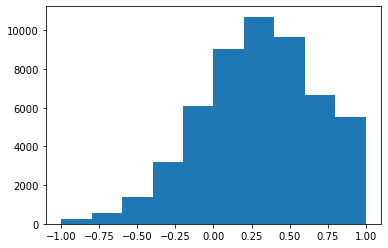

In [36]:
_ = plt.hist(generated.values())


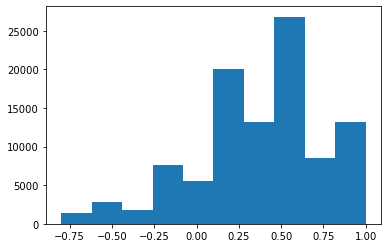

In [37]:
_ = plt.hist(rating_matrix.data)


0.2527556866894799

In [28]:
np.mean(list(generated.values())), np.mean(list(rating_matrix.data))

(0.22213314203085036, 0.4006227934467849)

In [25]:
rating_df = []
for ijr in rating_matrix.items():
    (i, j), r = ijr
    rating_df.append((i, j, r))
rating_df = pd.DataFrame(rating_df)


In [26]:
from surprise import dataset, Reader

b = dataset.DatasetAutoFolds(df = rating_df, reader = Reader(rating_scale=(-1.0, 1.0)))
ds = b.build_full_trainset()


In [27]:
m = SVDpp(n_epochs=1)
model = m.fit(ds)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "d:\onedrive\projects\aimchess-analytics\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-b4ec94e7139c>", line 2, in <module>
    model = m.fit(ds)
  File "surprise\prediction_algorithms\matrix_factorization.pyx", line 397, in surprise.prediction_algorithms.matrix_factorization.SVDpp.fit
  File "surprise\prediction_algorithms\matrix_factorization.pyx", line 447, in surprise.prediction_algorithms.matrix_factorization.SVDpp.sgd
  File "d:\onedrive\projects\aimchess-analytics\venv\lib\site-packages\surprise\trainset.py", line 189, in all_ratings
    yield u, i, r
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\onedrive\projects\aimchess-analytics\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._rende

KeyboardInterrupt: 

In [ ]:
model.yj.shape


In [ ]:
model.pu.shape


In [ ]:
model.qi.shape


In [31]:
original_dataset = rating_matrix
synthetic_dataset = new_matrix


In [93]:
random_items = np.random.choice(list(range(synthetic_dataset.shape[1])), size=10)


In [33]:
sparsity = len(original_dataset) / original_dataset.shape[0] / original_dataset.shape[1]


20000263

In [91]:
from collections import Counter

item_counts = Counter()
user_counts = Counter()

for (u, v), _ in synthetic_dataset.items():
    user_counts[u] += 1
    item_counts[v] += 1

item_counts = np.array([item_counts[i] for i in range(max(item_counts.keys()) + 1)])
user_counts = np.array([user_counts[i] for i in range(max(user_counts.keys()) + 1)])


In [81]:
user_sums = np.array(synthetic_dataset.sum(axis=1))[:, 0]
item_sums = np.array(synthetic_dataset.sum(axis=0))[0, :]


In [82]:
item_sums.shape


(26744,)

(array([2.656e+04, 1.180e+02, 3.300e+01, 1.100e+01, 8.000e+00, 7.000e+00,
        4.000e+00, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([ 0.        ,  2.86500493,  5.73000987,  8.5950148 , 11.46001973,
        14.32502467, 17.1900296 , 20.05503453, 22.92003947, 25.7850444 ,
        28.65004933]),
 <a list of 10 Patch objects>)

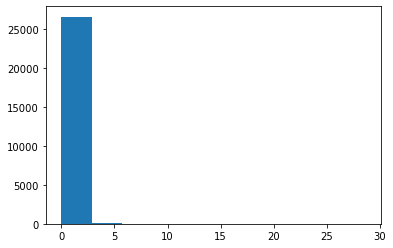

In [83]:
plt.hist(item_sums)


(array([937.,  44.,   6.,   9.,   1.,   1.,   1.,   0.,   0.,   1.]),
 array([ 0.        ,  9.41464707, 18.82929413, 28.2439412 , 37.65858826,
        47.07323533, 56.4878824 , 65.90252946, 75.31717653, 84.7318236 ,
        94.14647066]),
 <a list of 10 Patch objects>)

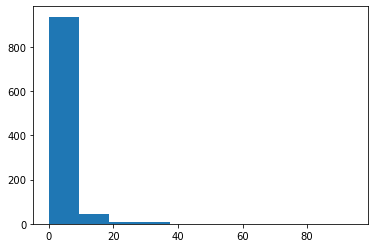

In [84]:
plt.hist(user_sums)


In [94]:
item_means_sample = (item_sums / item_counts)[random_items]
print(item_means_sample)


[1.54649556e-02            nan 2.59778938e-04 2.19937206e-05
 2.59513045e-03            nan 1.09556168e-04 8.76767122e-03
 6.58392844e-04 1.50967615e-01]


d:\onedrive\projects\aimchess-analytics\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [ ]:
item_sums.shape


In [ ]:
item_counts.shape


# NN model

In [90]:
from scipy.sparse import dok_matrix, csc_matrix

In [91]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

In [133]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=200):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.item_implicit_factors = torch.nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        predicted_ratings = (self.user_factors(user) * self.item_factors(item)).sum(2)
        predicted_probas = (self.user_factors(user) * self.item_implicit_factors(item)).sum(2)
        predicted_probas = torch.sigmoid(predicted_probas)
        return predicted_ratings, predicted_probas

In [134]:
model = MatrixFactorization(len(id_to_user), len(id_to_item))

In [135]:
#model.user_factors = torch.nn.Embedding(len(id_to_user), 200, _weight = torch.autograd(mf.user_vectors, requires_grad=True))
model.user_factors = torch.nn.Embedding(len(id_to_user), 200, _weight = torch.FloatTensor(mf.user_vectors))
model.item_factors = torch.nn.Embedding(len(id_to_item), 200, _weight = torch.FloatTensor(mf.item_vectors))
# model.user_factors.weight = nn.Parameter(t) #torch.FloatTensor(mf.user_vectors))
# model.item_factors.weight = nn.Parameter(t2) #torch.FloatTensor(mf.item_vectors))

### model.user_factors.weight

In [136]:
# Baseline metrics
mif = model.item_factors.weight.data.cpu().numpy()
muf = model.user_factors.weight.data.cpu().numpy()

loss = []
for (u, i), r in dok_matrix(rating_matrix).items():
    loss.append((muf[u].dot(mif[i]) - r) ** 2)
print(np.mean(loss))

0.030168048209296288


In [137]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # learning rate

In [138]:
m2 = dok_matrix(rating_matrix)


In [202]:
lsum, lsum2 = [], []
crossentropy = torch.nn.BCELoss()

for _ in range(200):
    for j, ((u, i), r) in enumerate(m2.items()):
        if (j % 256 == 0) or (j == len(m2.items())):
            if j > 0:
                optimizer.zero_grad()

                rating = torch.FloatTensor([batch_r])
                u_tensor = torch.LongTensor([batch_u])
                i_tensor = torch.LongTensor([batch_i])
                ones_tensor = torch.FloatTensor([1.0] * len(batch_i))

                batch_unrated_items = [np.random.randint(0, len(id_to_item)) for _ in range(len(batch_u))]
                batch_unrated_items_tensor = torch.LongTensor(batch_unrated_items)
                zeroes_tensor = torch.FloatTensor([0.0] * len(batch_i))
                
                predicted_ratings, rated_items_proba  = model(u_tensor, i_tensor)
                _, unrated_items_proba  = model(u_tensor, batch_unrated_items_tensor)
                
                proba_loss = (
                    crossentropy(rated_items_proba, ones_tensor) +
                    crossentropy(unrated_items_proba, zeroes_tensor)
                )
                rating_loss = ((rating - predicted_ratings) * (rating - predicted_ratings)).mean()
                
                loss = rating_loss + proba_loss * 2.0
                
                lsum2.append(rating_loss.item())
                lsum.append(proba_loss.item())

                loss.backward()
                optimizer.step()
            batch_u = []
            batch_i = []
            batch_r = []

        batch_u.append(u)
        batch_r.append(r)
        batch_i.append(i)

    print(np.mean(lsum), np.mean(lsum2))
    lsum, lsum2 = [], []

d:\onedrive\projects\aimchess-analytics\venv\lib\site-packages\torch\nn\modules\loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([1, 256])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


0.28727314945395666 0.06520082411989
0.28850390159219275 0.06609943108135508
0.28491302917097666 0.06088983605002022
0.28524985795712654 0.055966332289402114
0.28731323799483344 0.05645346065210629
0.29064240124616914 0.05952502015039666
0.28921248835840907 0.06209269390647648
0.28747111729538166 0.0627864534675165
0.2834225676896918 0.06156456680925748
0.28854550045865185 0.0590661207531548
0.2839845569458323 0.05776887542494684
0.28644775549949886 0.05781591299722213
0.2859934131607755 0.058566011393646554
0.28586952308662067 0.05876920306841836
0.285344339016133 0.05809296635346862
0.28550859004183277 0.05760372156139852
0.28387018105455936 0.05732966458031543
0.2835933088535874 0.057393217312394815
0.2827312393877039 0.05685461288834649
0.2856720908528369 0.05625276489813667
0.2814912675446226 0.0559839932176903
0.28207057888877907 0.05611716689537197
0.2839245988819132 0.05640370112490715
0.2788703298295727 0.056338698809383476
0.28008842784863996 0.05601782260732796
0.28165978041

KeyboardInterrupt: 

In [203]:
# Baseline metrics
mif = model.item_factors.weight.data.cpu().numpy()
miif = model.item_implicit_factors.weight.data.cpu().numpy()
muf = model.user_factors.weight.data.cpu().numpy()

loss = []
for (u, i), r in dok_matrix(rating_matrix).items():
    loss.append((muf[u].dot(mif[i]) - r) ** 2)
print(np.mean(loss))

0.04764193337170719


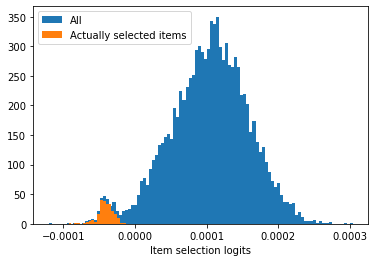

In [204]:
u = 0
rated_items = mf.ratings[u, :].nonzero()[1]

probas = np.dot(miif, muf[u, :])
probas = probas / np.sum(probas)

plt.hist(probas, bins=100, label="All")
plt.hist(probas[rated_items], label="Actually selected items", bins=20)
plt.xlabel("Item selection logits")
plt.legend()

In [205]:
sampled_items = np.random.choice(list(range(len(probas))), 100, False, p=probas)
ratings = np.dot(mif[sampled_items], muf[u])
plt.hist(ratings)
ratings2 = np.dot(mif[rated_items], muf[u])
plt.hist(ratings2, label="Actual")

ValueError: probabilities are not non-negative

In [206]:
from scipy.sparse import csc_matrix, dok_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sparsesvd import sparsesvd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

gmm = GaussianMixture(20, verbose=2, verbose_interval=1)
gmm.fit(muf)

Initialization 0
  Iteration 1	 time lapse 0.16955s	 ll change inf
  Iteration 2	 time lapse 0.07480s	 ll change 0.00000
Initialization converged: True	 time lapse 0.24534s	 ll 850.07607


GaussianMixture(n_components=20, verbose=2, verbose_interval=1)

In [207]:
new_uf, _ = gmm.sample(200)

rating_matrix = dok_matrix((200, len(id_to_item)))

ids = list(range(len(id_to_item)))

In [208]:
for u in range(200):
    ratings_count = int(50)
    
    v = muf[u, :]
    dotproducts = np.dot(miif, v)
    logits = 1 / (1 + np.exp(-dotproducts))
    probas = logits / np.sum(logits)

    sampled_items = np.random.choice(ids, ratings_count, False, p=probas)
    sampled_rating = mif[sampled_items].dot(v)
    sampled_rating = np.minimum(1.0, np.maximum(sampled_rating, -1.0))

    for i, r in zip(sampled_items, sampled_rating):
        rating_matrix[u, i] = r

(array([ 772., 1252., 2215., 2515., 3231.]),
 array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ]),
 <a list of 5 Patch objects>)

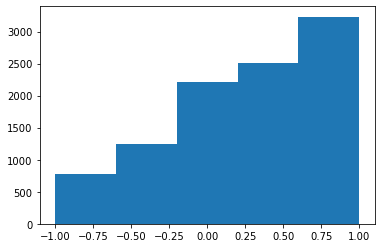

In [209]:
plt.hist(rating_matrix.values(), bins=5)

(array([ 4181.,  9342., 25597., 39954., 21762.]),
 array([-0.8 , -0.44, -0.08,  0.28,  0.64,  1.  ]),
 <a list of 5 Patch objects>)

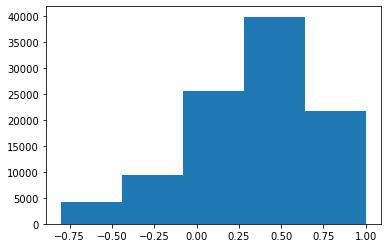

In [201]:
plt.hist(rating_matrix.data, bins=5)

In [196]:
import csv

def calculateTestAverage(fileName):
    file = open(fileName, "r")
    csvReader = csv.reader(file)
    
    header = next(csvReader)
    tests = 0
    totalScore = 0
    
    for row in csvReader:
        tests += 1
        print(row)
        totalScore += int(row[1])
    file.close()
    
    print(totalScore/tests)

In [198]:
calculateTestAverage("test")

['1', '2']
['3', '5']
3.5
